In [1]:
import tensorflow as tf

# Số lượng điểm dữ liệu cho mỗi lần huấn luyện
window_size = 30  # Thay bằng số bước thời gian bạn muốn dự báo

# Xây dựng Generator
def build_generator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Reshape((window_size, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Xây dựng Discriminator
def build_discriminator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

# Tạo Generator và Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Kết hợp Generator và Discriminator thành mô hình GAN
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                      loss='binary_crossentropy', metrics=['accuracy'])

# Đóng băng Discriminator khi huấn luyện GAN
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(window_size,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.models.Model(gan_input, gan_output)

# Compile GAN
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
            loss='binary_crossentropy')

# Print model summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()
print("\nGAN Summary:")
gan.summary()


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [128], output_shape = [30, 1]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 128), dtype=float32)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
import pandas as pd
data=pd.read_csv('excel_vcb.csv')
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

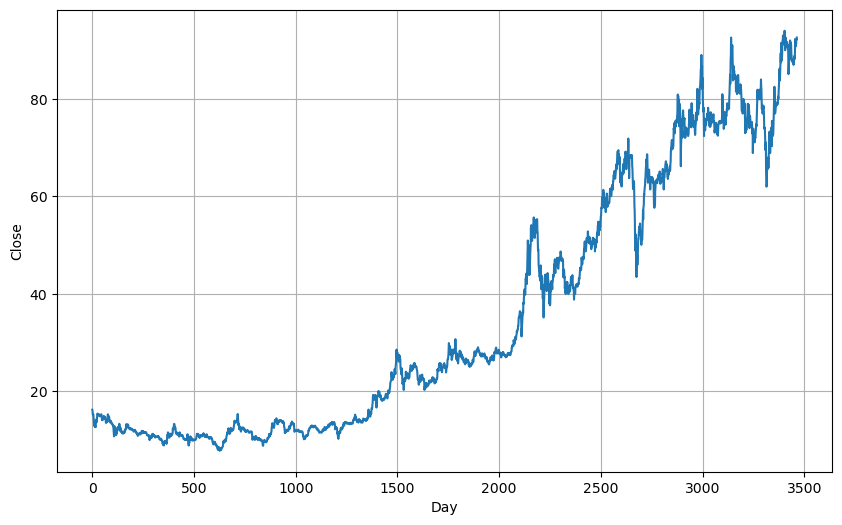

In [4]:
import csv
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
# Xây dựng Generator
def build_generator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Reshape((window_size, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Xây dựng Discriminator
def build_discriminator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

# Tạo Generator và Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Kết hợp Generator và Discriminator thành mô hình GAN
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                      loss='binary_crossentropy', metrics=['accuracy'])

# Đóng băng Discriminator khi huấn luyện GAN
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(window_size,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.models.Model(gan_input, gan_output)

# Compile GAN
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
            loss='binary_crossentropy')


In [11]:
# Print model summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()
print("\nGAN Summary:")
gan.summary()

Generator Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 reshape_1 (Reshape)         (None, 20, 1)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          33792     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75,493
Trainable para

In [14]:
import numpy as np

# Số epoch huấn luyện và kích thước batch
epochs = 100
batch_size = 64

# Hàm để huấn luyện GAN
def train_gan(gan, generator, discriminator, data, epochs, batch_size, window_size):
    for epoch in range(epochs):
        # Tạo batch dữ liệu thật
        real_data = np.array([data[i:i + window_size] for i in range(len(data) - window_size)])
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_batch = real_data[idx]
        
        # Tạo batch dữ liệu giả từ Generator
        noise = np.random.normal(0, 1, (batch_size, window_size))
        generated_data = generator.predict(noise)
        
        # Đảm bảo cả hai batch có cùng số chiều
        real_batch = np.expand_dims(real_batch, axis=-1)
        generated_data = np.expand_dims(generated_data, axis=-1)

        # Kết hợp và gán nhãn
        combined_data = np.concatenate([real_batch, generated_data], axis=0)
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        
        # Huấn luyện Discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(combined_data, labels)
        
        # Huấn luyện Generator
        noise = np.random.normal(0, 1, (batch_size, window_size))
        misleading_labels = np.ones((batch_size, 1))  # Muốn đánh lừa Discriminator
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, misleading_labels)
        
        # In tiến trình huấn luyện
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

# Huấn luyện mô hình GAN
train_gan(gan, generator, discriminator, data, epochs, batch_size, window_size)


2/2 [==============================] - 0s 25ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)